In [1]:
import os 
import sys
import numpy as np
import pandas as pd

import FINE as fn
import FINE.IOManagement.xarrayIO as xrIO 

# %load_ext autoreload
# %autoreload 2

In [2]:
"""Returns minimal instance of esM"""

numberOfTimeSteps = 4
hoursPerTimeStep = 2190

# Create an energy system model instance 
esM = fn.EnergySystemModel(locations={'ElectrolyzerLocation', 'IndustryLocation'}, 
                            commodities={'electricity', 'hydrogen'}, 
                            numberOfTimeSteps=numberOfTimeSteps,
                            commodityUnitsDict={'electricity': r'kW$_{el}$', 'hydrogen': r'kW$_{H_{2},LHV}$'},
                            hoursPerTimeStep=hoursPerTimeStep, costUnit='1 Euro', 
                            lengthUnit='km', 
                            verboseLogLevel=1,
                            balanceLimit=None,
                            lowerBound=False)

# time step length [h]
timeStepLength = numberOfTimeSteps * hoursPerTimeStep


### Buy electricity at the electricity market
costs = pd.DataFrame([np.array([ 0.05, 0., 0.1, 0.051,]),np.array([0., 0., 0., 0.,])],
                        index = ['ElectrolyzerLocation', 'IndustryLocation']).T
revenues = pd.DataFrame([np.array([ 0., 0.01, 0., 0.,]),np.array([0., 0., 0., 0.,])],
                        index = ['ElectrolyzerLocation', 'IndustryLocation']).T
maxpurchase = pd.DataFrame([np.array([1e6, 1e6, 1e6, 1e6,]),np.array([0., 0., 0., 0.,])],
                        index = ['ElectrolyzerLocation', 'IndustryLocation']).T * hoursPerTimeStep
esM.add(fn.Source(esM=esM, name='Electricity market', commodity='electricity', 
                    hasCapacityVariable=False, operationRateMax = maxpurchase,
                    commodityCostTimeSeries = costs,  
                    commodityRevenueTimeSeries = revenues 
                    )) # eur/kWh

### Electrolyzers
esM.add(fn.Conversion(esM=esM, name='Electrolyzers', physicalUnit=r'kW$_{el}$',
                        commodityConversionFactors={'electricity':-1, 'hydrogen':0.7},
                        hasCapacityVariable=True, 
                        investPerCapacity=500, # euro/kW
                        opexPerCapacity=500*0.025, 
                        interestRate=0.08,
                        economicLifetime=10))

### Hydrogen filled somewhere
esM.add(fn.Storage(esM=esM, name='Pressure tank', commodity='hydrogen',
                    hasCapacityVariable=True, capacityVariableDomain='continuous',
                    stateOfChargeMin=0.33, 
                    investPerCapacity=0.5, # eur/kWh
                    interestRate=0.08,
                    economicLifetime=30))

### Hydrogen pipelines
esM.add(fn.Transmission(esM=esM, name='Pipelines', commodity='hydrogen',
                        hasCapacityVariable=True,
                        investPerCapacity=0.177, 
                        interestRate=0.08, 
                        economicLifetime=40))

### Industry site
demand = pd.DataFrame([np.array([0., 0., 0., 0.,]), np.array([6e3, 6e3, 6e3, 6e3,]),],
                index = ['ElectrolyzerLocation', 'IndustryLocation']).T * hoursPerTimeStep
esM.add(fn.Sink(esM=esM, name='Industry site', commodity='hydrogen', hasCapacityVariable=False,
                operationRateFix = demand
                ))

In [3]:
esM.optimize()

Using license file C:\Users\k.knosala\gurobi.lic
Academic license - for non-commercial use only
Read LP format model from file C:\Users\K7BCD~1.KNO\AppData\Local\Temp\tmp7vlrhkzw.pyomo.lp
Reading time = 0.00 seconds
x103: 91 rows, 63 columns, 221 nonzeros
Changed value of parameter QCPDual to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Changed value of parameter Threads to 3
   Prev: 0  Min: 0  Max: 1024  Default: 0
Parameter logfile unchanged
   Value:   Default: 
Gurobi Optimizer version 9.0.3 build v9.0.3rc0 (win64)
Optimize a model with 91 rows, 63 columns and 221 nonzeros
Model fingerprint: 0xc4afb60b
Coefficient statistics:
  Matrix range     [3e-01, 2e+03]
  Objective range  [7e-03, 9e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 41 rows and 29 columns
Presolve time: 0.00s
Presolved: 50 rows, 34 columns, 168 nonzeros

Iteration    O

In [4]:
# Save esM to netCDF
output = fn.IOManagement.esm_to_netcdf(esM)
# esM.to_netcdf()

 c:\users\k.knosala\tools\fine\FINE\IOManagement\utilsIO.py:70: UserWarning:Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
 c:\users\k.knosala\tools\fine\FINE\IOManagement\utilsIO.py:70: UserWarning:Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
 c:\users\k.knosala\tools\fine\FINE\IOManagement\utilsIO.py:70: UserWarning:Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
 c:\users\k.knosala\tools\fine\FINE\IOManagement\utilsIO.py:70: UserWarning:Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


In [5]:
output

{'Results': {'SourceSinkModel': {'Electricity market': <xarray.Dataset>
   Dimensions:                    (space: 2, time: 4)
   Coordinates:
     * space                      (space) <U20 'ElectrolyzerLocation' 'IndustryL...
     * time                       (time) int64 0 1 2 3
   Data variables:
       TAC                        (space) float64 1.52e+06 0.0
       commodCosts                (space) float64 1.896e+06 nan
       commodRevenues             (space) float64 3.754e+05 nan
       operation                  (space) float64 7.509e+07 nan
       operationVariablesOptimum  (time, space) float64 1.877e+07 nan ... nan,
   'Industry site': <xarray.Dataset>
   Dimensions:                    (space: 2, time: 4)
   Coordinates:
     * space                      (space) <U20 'ElectrolyzerLocation' 'IndustryL...
     * time                       (time) int64 0 1 2 3
   Data variables:
       operation                  (space) float64 nan 5.256e+07
       operationVariablesOptimum  (ti

In [6]:
print(output.keys())
print(output["Results"].keys())
print(output["Results"]["ConversionModel"].keys())

dict_keys(['Results', 'Input', 'Parameters'])
dict_keys(['SourceSinkModel', 'ConversionModel', 'StorageModel', 'TransmissionModel'])
dict_keys(['Electrolyzers'])


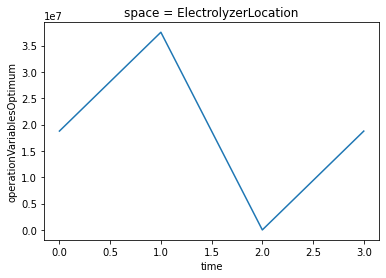

In [7]:
output["Results"]["ConversionModel"]["Electrolyzers"]["operationVariablesOptimum"].loc[:,"ElectrolyzerLocation"].plot()

In [8]:
read = fn.IOManagement.netcdf_to_datasets("my_esm.nc")

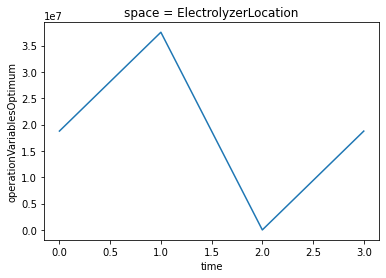

In [9]:
read["Results"]["ConversionModel"]["Electrolyzers"]["operationVariablesOptimum"].loc[:,"ElectrolyzerLocation"].plot()

In [10]:
read.keys()

dict_keys(['Results', 'Input', 'Parameters'])

In [11]:
read["Input"]["Source"]["Electricity market"]

<xarray.Dataset>
Dimensions:                        (space: 2, time: 4)
Coordinates:
  * time                           (time) int64 0 1 2 3
  * space                          (space) object 'ElectrolyzerLocation' 'Ind...
Data variables: (12/36)
    ts_operationRateMax            (time, space) float64 ...
    ts_commodityCostTimeSeries     (time, space) float64 ...
    ts_commodityRevenueTimeSeries  (time, space) float64 ...
    1d_locationalEligibility       (space) float64 ...
    1d_investPerCapacity           (space) float64 ...
    1d_investIfBuilt               (space) float64 ...
    ...                             ...
    0d_linkedQuantityID            float64 ...
    0d_capacityFix                 float64 ...
    0d_isBuiltFix                  float64 ...
    0d_yearlyFullLoadHoursMin      float64 ...
    0d_yearlyFullLoadHoursMax      float64 ...
    0d_balanceLimitID              float64 ...

In [12]:
esm_from_file = fn.IOManagement.datasets_to_esm(read)

 c:\users\k.knosala\tools\fine\FINE\IOManagement\utilsIO.py:70: UserWarning:Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
 c:\users\k.knosala\tools\fine\FINE\IOManagement\utilsIO.py:70: UserWarning:Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
 c:\users\k.knosala\tools\fine\FINE\IOManagement\utilsIO.py:70: UserWarning:Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
 c:\users\k.knosala\tools\fine\FINE\IOManagement\utilsIO.py:70: UserWarning:Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


In [14]:
esm_from_file.optimize()

Using license file C:\Users\k.knosala\gurobi.lic
Academic license - for non-commercial use only
Read LP format model from file C:\Users\K7BCD~1.KNO\AppData\Local\Temp\tmp1dcufm3d.pyomo.lp
Reading time = 0.01 seconds
x103: 91 rows, 63 columns, 221 nonzeros
Changed value of parameter QCPDual to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Changed value of parameter Threads to 3
   Prev: 0  Min: 0  Max: 1024  Default: 0
Parameter logfile unchanged
   Value:   Default: 
Gurobi Optimizer version 9.0.3 build v9.0.3rc0 (win64)
Optimize a model with 91 rows, 63 columns and 221 nonzeros
Model fingerprint: 0x66ab0644
Coefficient statistics:
  Matrix range     [3e-01, 2e+03]
  Objective range  [4e-03, 9e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 41 rows and 29 columns
Presolve time: 0.00s
Presolved: 50 rows, 34 columns, 168 nonzeros

Iteration    O

In [18]:
esm_from_file.getOptimizationSummary("SourceSinkModel")

ElectrolyzerLocation  \
Component          Property       Unit                                          
Electricity market TAC            [1 Euro/a]                      1.52049e+06   
                   capacity       [kW$_{el}$]                             NaN   
                   capexCap       [1 Euro/a]                              NaN   
                   capexIfBuilt   [1 Euro/a]                              NaN   
                   commodCosts    [1 Euro/a]                      1.89591e+06   
                   commodRevenues [1 Euro/a]                           375429   
                   invest         [1 Euro]                                NaN   
                   isBuilt        [-]                                     NaN   
                   operation      [kW$_{el}$*h/a]                 7.50857e+07   
                                  [kW$_{el}$*h]                   7.50857e+07   
                   opexCap        [1 Euro/a]                              NaN   
                   opexIfBuilt    [1 Euro/a]                              NaN   
                   opexOp         [1 Euro/a]                                0   
Industry site      TAC            [1 Euro/a]                                0   
                   capacity       [kW$_{H_{2},LHV}$]                      NaN   
                   capexCap       [1 Euro/a]                              NaN   
                   capexIfBuilt   [1 Euro/a]                              NaN   
                   commodCosts    [1 Euro/a]                              NaN   
                   commodRevenues [1 Euro/a]                              NaN   
                   invest         [1 Euro]                                NaN   
                   isBuilt        [-]                                     NaN   
                   operation      [kW$_{H_{2},LHV}$*h/a]                  NaN   
                                  [kW$_{H_{2},LHV}$*h]                    NaN   
                   opexCap        [1 Euro/a]                              NaN   
                   opexIfBuilt    [1 Euro/a]                              NaN   
                   opexOp         [1 Euro/a]                              NaN   

                                                         IndustryLocation  
Component          Property       Unit                                     
Electricity market TAC            [1 Euro/a]                            0  
                   capacity       [kW$_{el}$]                         NaN  
                   capexCap       [1 Euro/a]                          NaN  
                   capexIfBuilt   [1 Euro/a]                          NaN  
                   commodCosts    [1 Euro/a]                          NaN  
                   commodRevenues [1 Euro/a]                          NaN  
                   invest         [1 Euro]                            NaN  
                   isBuilt        [-]                                 NaN  
                   operation      [kW$_{el}$*h/a]                     NaN  
                                  [kW$_{el}$*h]                       NaN  
                   opexCap        [1 Euro/a]                          NaN  
                   opexIfBuilt    [1 Euro/a]                          NaN  
                   opexOp         [1 Euro/a]                          NaN  
Industry site      TAC            [1 Euro/a]                            0  
                   capacity       [kW$_{H_{2},LHV}$]                  NaN  
                   capexCap       [1 Euro/a]                          NaN  
                   capexIfBuilt   [1 Euro/a]                          NaN  
                   commodCosts    [1 Euro/a]                            0  
                   commodRevenues [1 Euro/a]                            0  
                   invest         [1 Euro]                            NaN  
                   isBuilt        [-]                                 NaN  
                   operation      [kW$_{

In [19]:
esm_from_file.declareOptimizationProblem()